## Importing Libraries

In [235]:
import warnings
warnings.filterwarnings('ignore')

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from yellowbrick.cluster import KElbowVisualizer
import networkx as nx

In [237]:
import os

os.makedirs("plots", exist_ok=True)

## Load Data

In [238]:
df = pd.read_excel('Online Retail.xlsx')

In [239]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Cleaning

In [240]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [241]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
TotalPrice          0
dtype: int64

In [242]:
# Drop missing CustomerID only for customer analysis
df_customer = df.dropna(subset=['CustomerID']).copy()
df_customer['CustomerID'] = df_customer['CustomerID'].astype(str)

## EDA

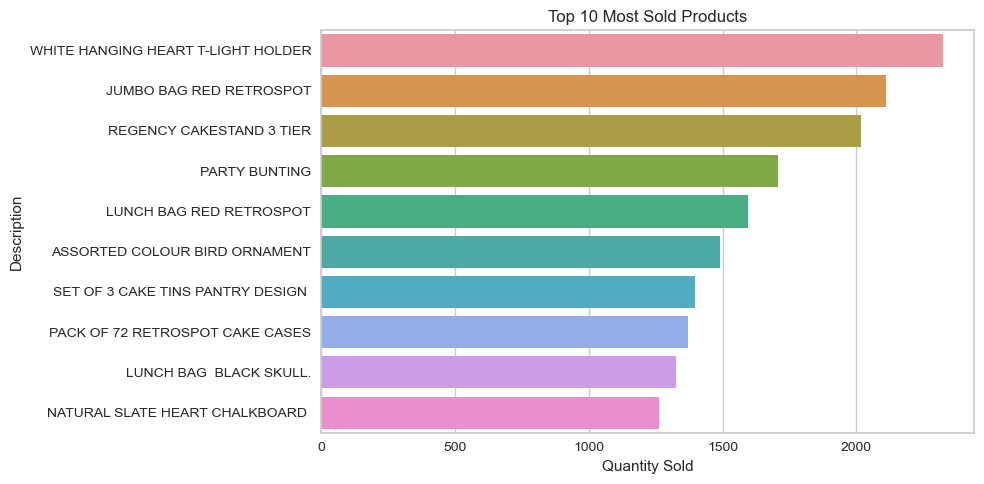

In [243]:
# Top 10 most sold products
top_products = df['Description'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Most Sold Products")
plt.xlabel("Quantity Sold")
plt.tight_layout()
plt.savefig('plots/top_10_most_sold_products.png')
plt.show()

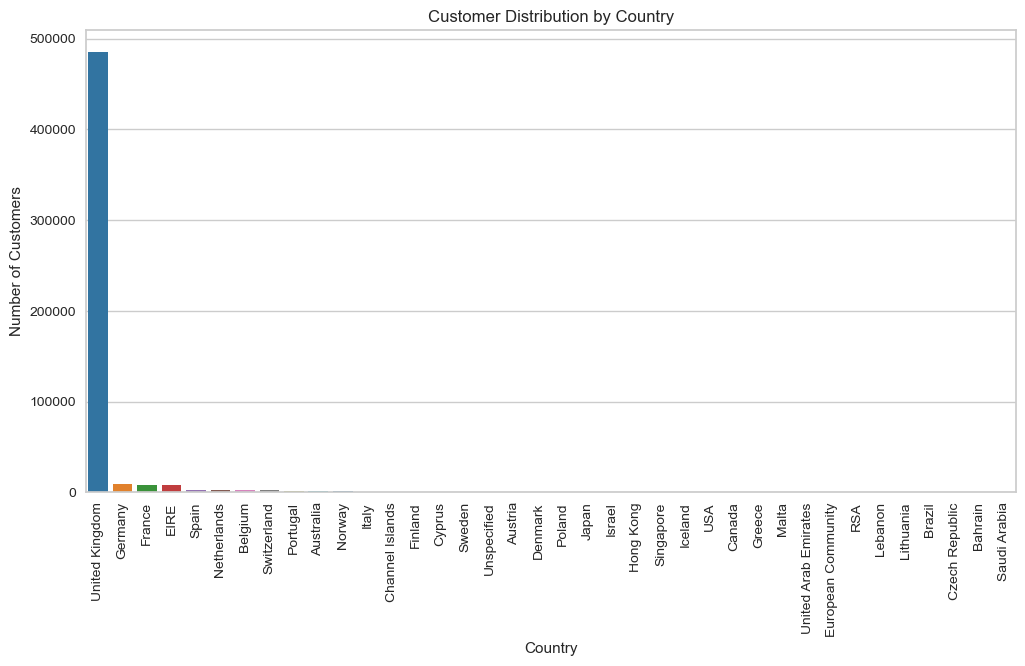

In [244]:
country_counts = df['Country'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts.index, y=country_counts.values, palette='tab10')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Titles and labels
plt.title('Customer Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.savefig('plots/customer_distribution_by_country.png')

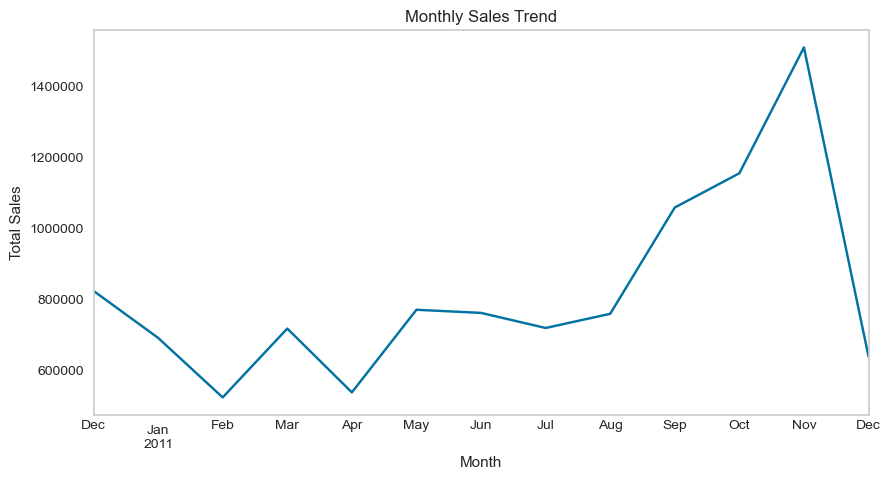

In [245]:
# Monthly sales trend
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalPrice'].sum()
monthly_sales.plot(kind='line', title='Monthly Sales Trend', figsize=(10,5))
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Total Sales')
plt.grid()
plt.savefig('plots/monthly_sales_trend.png')
plt.show()


Observation
- Sales are the lowest in February and April and the highest in October, November
- There is a steep increase in sales after July till November

In [246]:
df[['UnitPrice','Quantity']].describe()

,UnitPrice,Quantity
count,530104.000000,530104.000000
mean,3.907625,10.542037
std,35.915681,155.524124
min,0.001000,1.000000
25%,1.250000,1.000000
50%,2.080000,3.000000
75%,4.130000,10.000000
max,13541.330000,80995.000000


In [247]:
# RFM (Recency, Frequency, Monetary) calculation
snapshot_date = df_customer['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df_customer.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


In [248]:
top_spending_customers = rfm.sort_values(by='Monetary', ascending=False)
top_spending_customers

,Recency,Frequency,Monetary
CustomerID,,,
14646.0,2,73,280206.02
18102.0,1,60,259657.30
17450.0,8,46,194550.79
16446.0,1,2,168472.50
14911.0,1,201,143825.06
...,...,...,...
16878.0,84,1,13.30
17956.0,249,1,12.75
16454.0,45,2,6.90


In [249]:
top_spending_customers[:10]

,Recency,Frequency,Monetary
CustomerID,,,
14646.0,2,73,280206.02
18102.0,1,60,259657.30
17450.0,8,46,194550.79
16446.0,1,2,168472.50
14911.0,1,201,143825.06
12415.0,24,21,124914.53
14156.0,10,55,117379.63
17511.0,3,31,91062.38
16029.0,39,63,81024.84


These are the customers who have spent the most

In [250]:
spent_per_visit = rfm.copy()
spent_per_visit['per_visit'] = spent_per_visit['Monetary']/rfm['Frequency']
spent_per_visit

,Recency,Frequency,Monetary,per_visit
CustomerID,,,,
12346.0,326,1,77183.60,77183.600000
12347.0,2,7,4310.00,615.714286
12348.0,75,4,1797.24,449.310000
12349.0,19,1,1757.55,1757.550000
12350.0,310,1,334.40,334.400000
...,...,...,...,...
18280.0,278,1,180.60,180.600000
18281.0,181,1,80.82,80.820000
18282.0,8,2,178.05,89.025000


In [251]:
high_spenders = spent_per_visit.sort_values(by='per_visit', ascending=False)
high_spenders[:10]

,Recency,Frequency,Monetary,per_visit
CustomerID,,,,
16446.0,1,2,168472.50,84236.250000
12346.0,326,1,77183.60,77183.600000
15749.0,235,3,44534.30,14844.766667
15098.0,182,3,39916.50,13305.500000
12357.0,33,1,6207.67,6207.670000
12415.0,24,21,124914.53,5948.310952
12590.0,211,2,9864.26,4932.130000
12688.0,114,1,4873.81,4873.810000
12752.0,81,1,4366.78,4366.780000


- These are people who spends the most in a single visit 
- This list can be used to identify top spenders and introduce coupons(like on spend of a fixed amount e.g. 4000 you'll get something free e.g. 500 worth of coupon you can use it next time or give a product for free)
- This will encourage people to buy more if they are just short to the limit 
- As we can see in the list 8 out of top 10 customers with highest per visit spend have frequency of 1,2 or 3, giving them a coupon for the next visit will encourage them to come again.

In [252]:
most_active_customers = spent_per_visit[spent_per_visit['Frequency']>10]
most_active_customers.sort_values(by='per_visit', ascending=False)[:10]

,Recency,Frequency,Monetary,per_visit
CustomerID,,,,
12415.0,24,21,124914.53,5948.310952
18102.0,1,60,259657.30,4327.621667
17450.0,8,46,194550.79,4229.365000
14088.0,10,13,50491.81,3883.985385
14646.0,2,73,280206.02,3838.438630
14096.0,4,17,65164.79,3833.222941
17511.0,3,31,91062.38,2937.496129
12931.0,22,15,42055.96,2803.730667
13081.0,12,11,28337.38,2576.125455


- These are the top 10 customers with the highest per visit spend with minimum 10 visits.
- This list may be used to introduce loyalty programs/rewards to mantain customer engagement.

## Kmeans Clustering

In [253]:
# Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

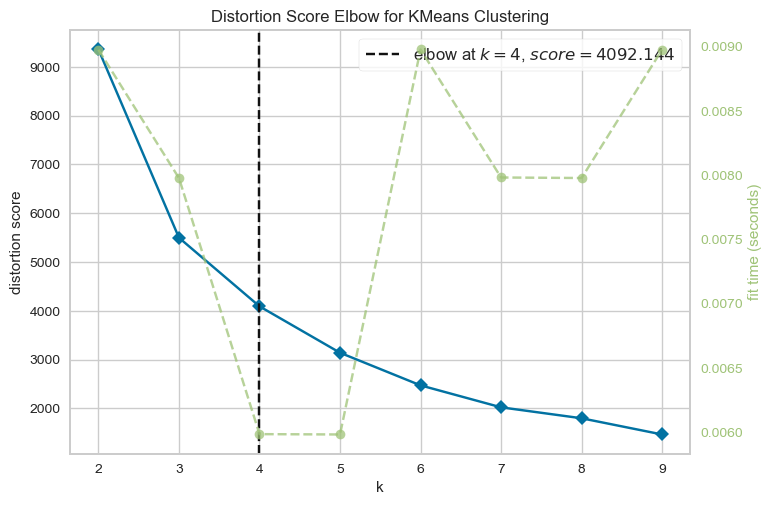

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [284]:
# KMeans Clustering
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(rfm_scaled)
visualizer.show()

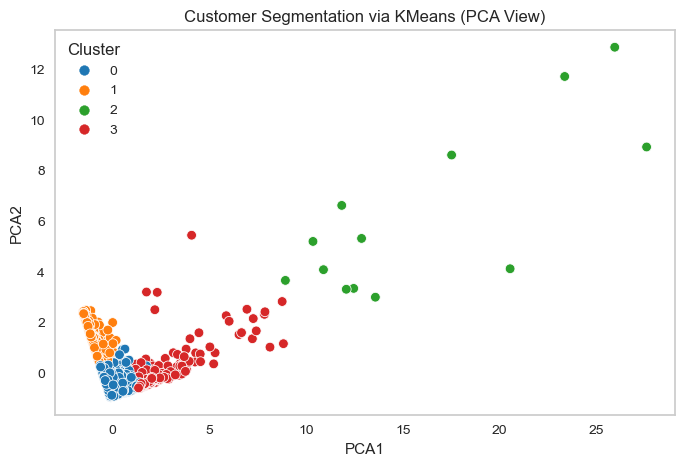

In [255]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize clusters (PCA)
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = rfm_pca[:,0]
rfm['PCA2'] = rfm_pca[:,1]

plt.figure(figsize=(8,5))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title("Customer Segmentation via KMeans (PCA View)")
plt.grid()
plt.savefig('plots/customer_segmentation_kmeans.png')
plt.show()

In [256]:
rfm_clustered = rfm.drop(['PCA1', 'PCA2'], axis=1)
rfm_clustered

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,3
12347.0,2,7,4310.00,0
12348.0,75,4,1797.24,0
12349.0,19,1,1757.55,0
12350.0,310,1,334.40,1
...,...,...,...,...
18280.0,278,1,180.60,1
18281.0,181,1,80.82,1
18282.0,8,2,178.05,0


In [257]:
rfm_clustered.groupby('Cluster')['Monetary'].mean()

Cluster
0      1359.049284
1       480.617480
2    127338.313846
3     12709.090490
Name: Monetary, dtype: float64

In [258]:
rfm_clustered.groupby('Cluster')['Frequency'].mean()

Cluster
0     3.682711
1     1.552015
2    82.538462
3    22.333333
Name: Frequency, dtype: float64

In [259]:
rfm_clustered.groupby('Cluster')['Recency'].mean()

Cluster
0     43.702685
1    248.075914
2      7.384615
3     15.500000
Name: Recency, dtype: float64

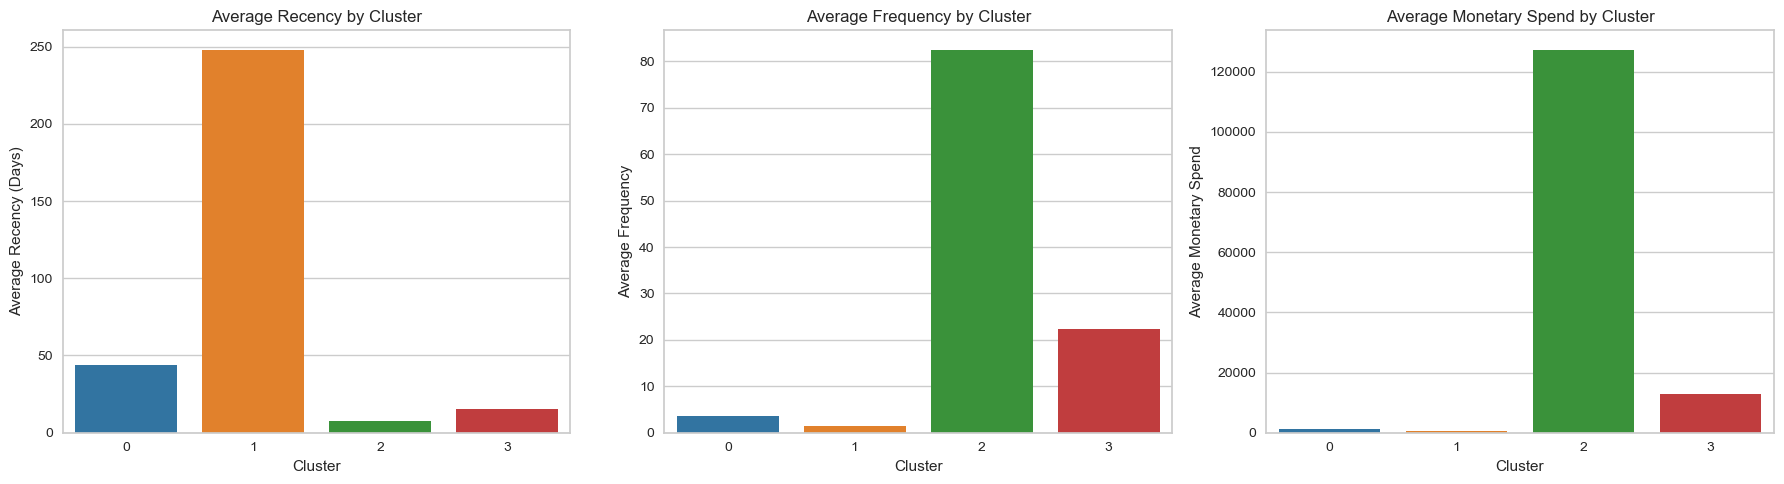

In [260]:
# Average Recency, Frequency, and Monetary by Cluster
rfm_avg = rfm_clustered.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Plotting the averages
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x='Cluster', y='Recency', data=rfm_avg, ax=axes[0], palette='tab10')
axes[0].set_title('Average Recency by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average Recency (Days)')

sns.barplot(x='Cluster', y='Frequency', data=rfm_avg, ax=axes[1], palette='tab10')
axes[1].set_title('Average Frequency by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Average Frequency')

sns.barplot(x='Cluster', y='Monetary', data=rfm_avg, ax=axes[2], palette='tab10')
axes[2].set_title('Average Monetary Spend by Cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Average Monetary Spend')

plt.tight_layout()
plt.savefig('plots/average_distribution_by_clusters.png')
plt.show()

Observations:  
- Cluster 1: Has least frequency, highest recency value, lowest monetary
    - Customers in cluster 1 are low spenderss, visit less and often which makes them occasional buyers  
- Cluster 0: Has 2nd least frequency, 2nd highest recency value, 2nd lowest monetary
    - Just like cluster 1 they are occasional spenders just they spend a little more and visit more often than cluster 1
- Cluster 2: Has highest frequency, lowest recency, highest moentary
    - this makes them the best customers, they spend a lot more than others, visit frequently
- Cluster 3: Has 2nd highest frequency, 2nd lowest recency, 2nd highest moentary
    - these are also very good customers
   

In [261]:
df1 = df.copy()
rfm_clustered = rfm_clustered.reset_index()
df1['CustomerID'] = pd.to_numeric(df1['CustomerID'], errors='coerce')
rfm_clustered['CustomerID'] = pd.to_numeric(rfm_clustered['CustomerID'], errors='coerce')

df1 = pd.merge(df1, rfm_clustered[['CustomerID', 'Cluster']], on='CustomerID', how='left')

In [262]:
df1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Month,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,3.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,3.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,3.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,3.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,3.0
...,...,...,...,...,...,...,...,...,...,...,...
530099,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12,0.0
530100,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12,0.0
530101,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12,0.0
530102,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12,0.0


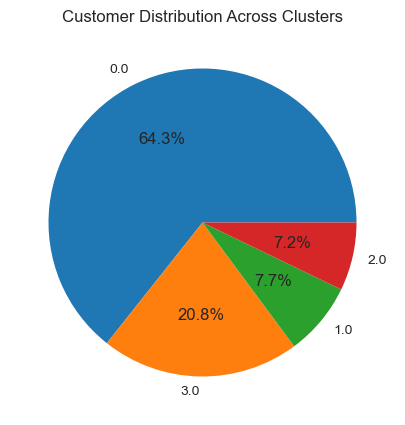

In [263]:
cluster_counts = df1['Cluster'].value_counts()

plt.figure(figsize=(8, 5))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', colors=sns.color_palette('tab10', len(cluster_counts)))
plt.title('Customer Distribution Across Clusters')
plt.savefig('plots/customer_distribution_across_clusters.png')
plt.show()

Observation:
- More than 60% customers belong to cluster 0
- Next big group is of cluster 3

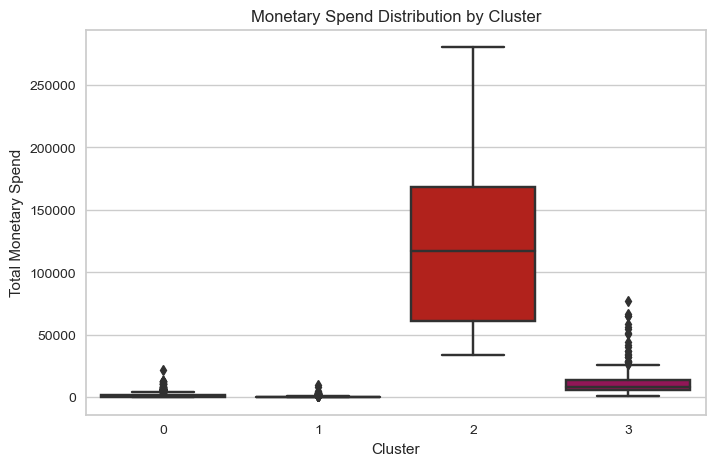

In [264]:
plt.figure(figsize=(8,5))
sns.boxplot(data=rfm, x='Cluster', y='Monetary')
plt.title('Monetary Spend Distribution by Cluster')
plt.ylabel('Total Monetary Spend')
plt.xlabel('Cluster')
plt.savefig('plots/monetary_spend_distribution_by_cluster.png')
plt.show()


Observation:
- minimum spend of cluster 2 is even higher than the maximum spends of cluster 0 and 1 

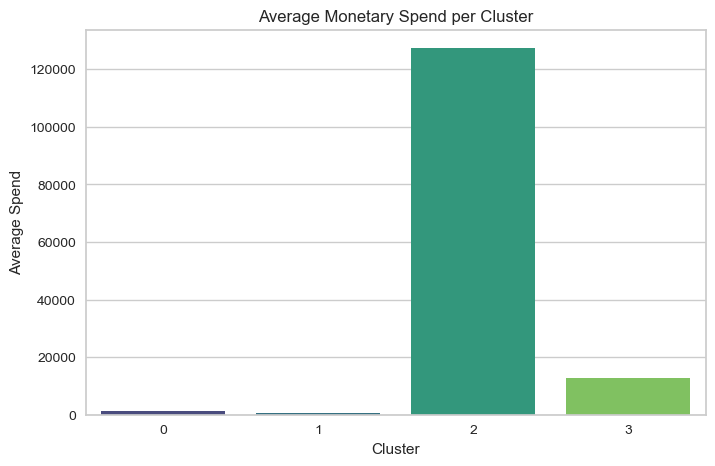

In [265]:
avg_spend = rfm.groupby('Cluster')['Monetary'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=avg_spend, x='Cluster', y='Monetary', palette='viridis')
plt.title('Average Monetary Spend per Cluster')
plt.ylabel('Average Spend')
plt.xlabel('Cluster')
plt.savefig('plots/average_monetary_spend_per_cluster.png')
plt.show()


Observation:
- Average monetary spend of cluster 2 is much higher 

In [266]:
sales_share = df1.groupby('Cluster')['TotalPrice'].sum().reset_index()
sales_share

,Cluster,TotalPrice
0,0.0,4150536.513
1,1.0,512818.851
2,2.0,1655398.080
3,3.0,2592654.460


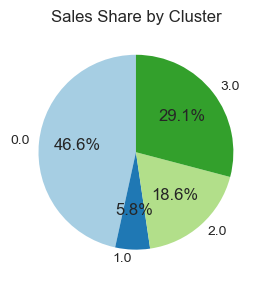

In [267]:
plt.figure(figsize=(3, 3))
plt.pie(sales_share['TotalPrice'], labels=sales_share['Cluster'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Sales Share by Cluster')
plt.tight_layout()
plt.savefig('plots/sales_share_by_cluster.png')
plt.show()

Observation:
- cluster 0 contributes the most almost half of the revenue is coming from cluster 0 and 30 % from cluster 3 

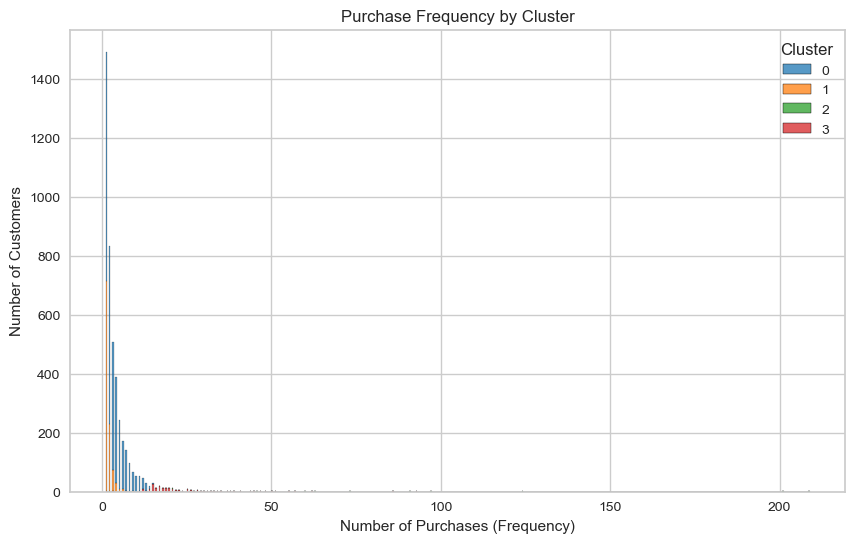

In [268]:
plt.figure(figsize=(10, 6))
sns.histplot(rfm_clustered, x='Frequency', hue='Cluster', multiple='stack', kde=False, palette='tab10')
plt.title('Purchase Frequency by Cluster')
plt.xlabel('Number of Purchases (Frequency)')
plt.ylabel('Number of Customers')
plt.savefig('plots/purchase_frequency_by_cluster.png')
plt.show()

In [269]:
df1['Country'].nunique()

38

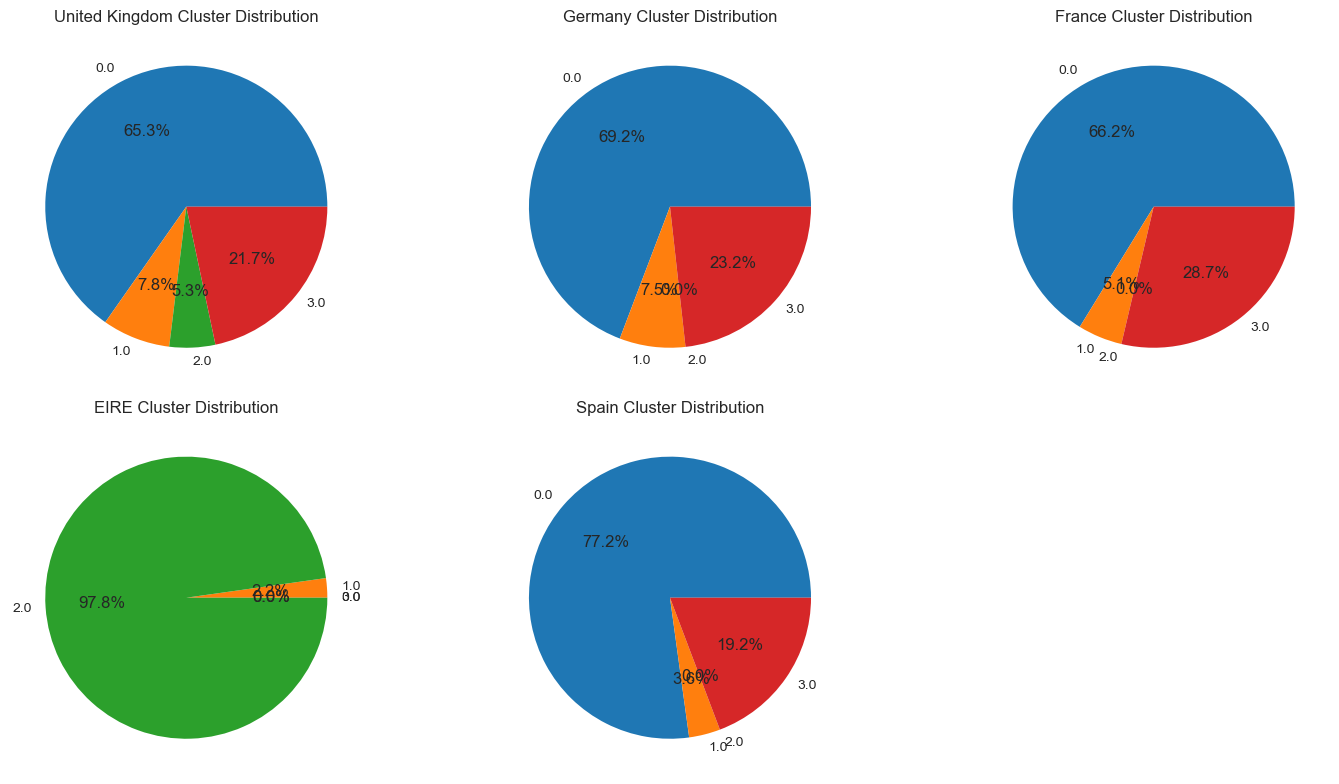

In [270]:
country_cluster_counts = df1.groupby('Country')['Cluster'].value_counts().unstack().fillna(0)

top_countries = df1['Country'].value_counts().head(5).index

plt.figure(figsize=(15, 8))
for i, country in enumerate(top_countries):
    plt.subplot(2, 3, i+1) 
    country_data = country_cluster_counts.loc[country]
    plt.pie(country_data, labels=country_data.index, autopct='%1.1f%%', colors=sns.color_palette('tab10', len(country_data)))
    plt.title(f'{country} Cluster Distribution')

plt.tight_layout()
plt.savefig('plots/countries_cluster_distribution.png')
plt.show()


<Figure size 1000x500 with 0 Axes>

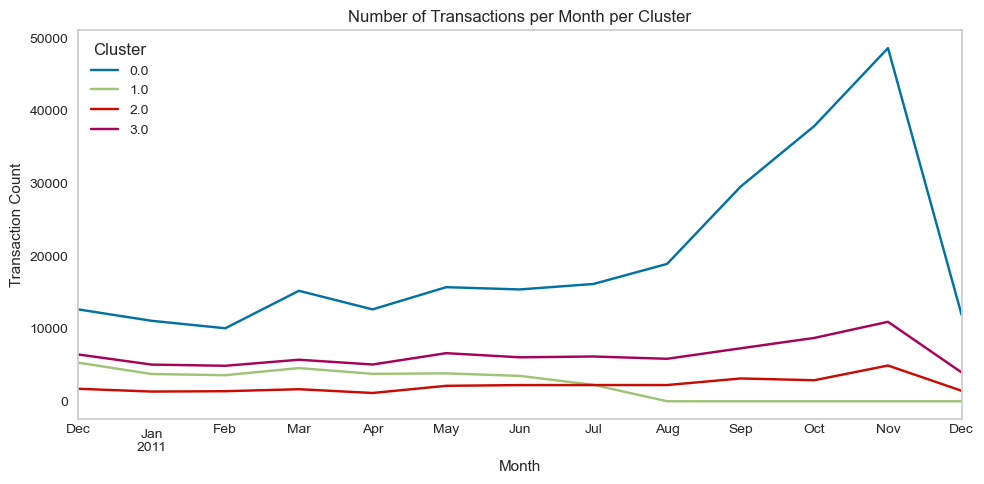

In [271]:
df1['Month'] = df1['InvoiceDate'].dt.to_period('M')
monthly_transactions = df1.groupby(['Month', 'Cluster']).size().unstack().fillna(0)
plt.figure(figsize=(10, 5))
monthly_transactions.plot(kind='line', title='Number of Transactions per Month per Cluster', figsize=(10, 5))

plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.grid()

plt.tight_layout()
plt.savefig('plots/#transactions_per_month_per_cluster.png')
plt.show()


Observation:
- Transaction count increases in the July-November period only for the cluster 0 
- For others it is uniform throught , with cluster 1 and 3 peak in November
- And no transactions from the cluster after August 

In [272]:
df1.groupby('Cluster')['Quantity'].mean()

Cluster
0.0     9.833977
1.0     9.312935
2.0    29.859270
3.0    18.293871
Name: Quantity, dtype: float64

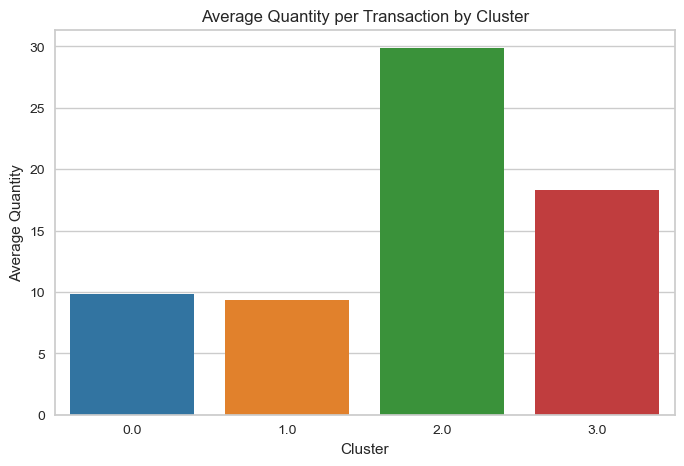

In [273]:
avg_quantity = df1.groupby('Cluster')['Quantity'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=avg_quantity, x='Cluster', y='Quantity', palette='tab10')
plt.title('Average Quantity per Transaction by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Quantity')
plt.savefig('plots/average_quantity_per_transactions_by_cluster.png')
plt.show()


Observations:
- cluster 2 has the highest average quantity purchased, may be because they buy in bulk

In [274]:
top_products = (
    df1.groupby(['Cluster', 'Description'])['Quantity']
    .sum()
    .reset_index()
    .sort_values(['Cluster', 'Quantity'], ascending=[True, False])
)

# Display top 5 products per cluster
top_5_per_cluster = top_products.groupby('Cluster').head(5)
top_5_per_cluster

,Cluster,Description,Quantity
3619,0.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,22097
1676,0.0,JUMBO BAG RED RETROSPOT,18187
209,0.0,ASSORTED COLOUR BIRD ORNAMENT,16802
2163,0.0,PACK OF 72 RETROSPOT CAKE CASES,16724
3535,0.0,WHITE HANGING HEART T-LIGHT HOLDER,13498
6532,1.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,5473
6169,1.0,SMALL POPCORN HOLDER,4989
3867,1.0,ASSORTED COLOURS SILK FAN,3860
6463,1.0,WHITE HANGING HEART T-LIGHT HOLDER,2244
5251,1.0,MINI PAINT SET VINTAGE,2197


### Product Clustering

In [275]:
# Create transaction matrix across all countries
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

# Convert quantities to binary (1 = bought, 0 = not bought)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Compute co-occurrence matrix
co_matrix = basket.T.dot(basket)

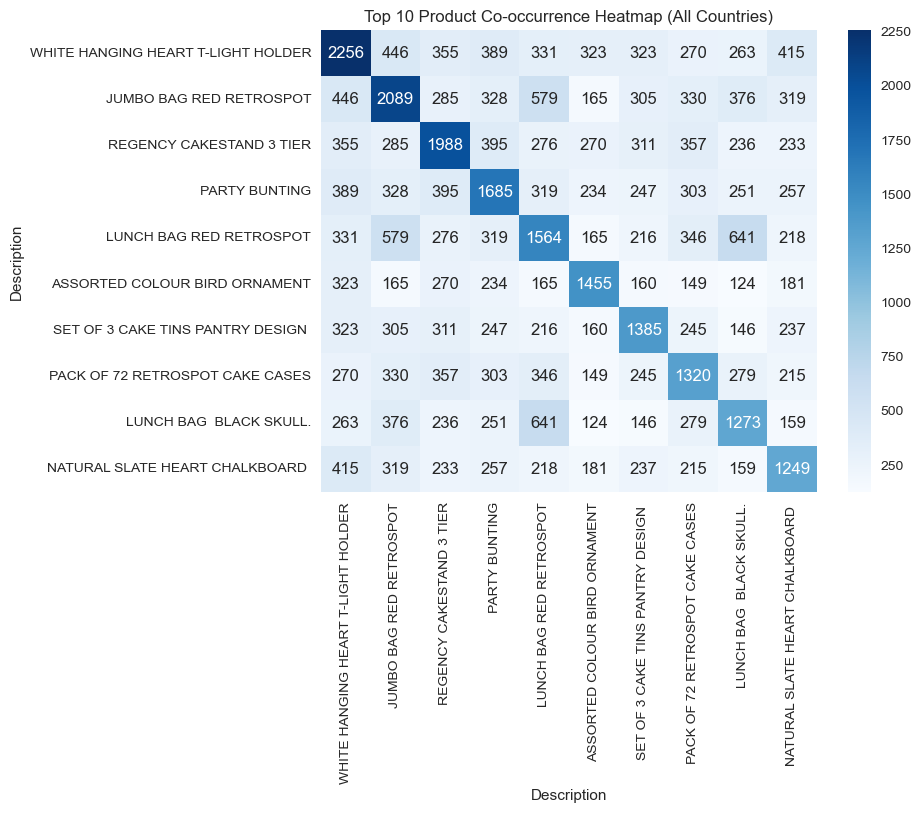

In [276]:
# Get top 10 most frequently purchased products
top_products = basket.sum().sort_values(ascending=False).head(10).index

# Slice the co-occurrence matrix
top_co_matrix = co_matrix.loc[top_products, top_products]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(top_co_matrix, cmap='Blues', annot=True, fmt='g')
plt.title("Top 10 Product Co-occurrence Heatmap (All Countries)")
plt.savefig('plots/Top 10 Product Co-occurrence Heatmap (All Countries)')
plt.show()


### Apriori

In [277]:
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)
rules = rules.sort_values(by='lift', ascending=False)

# Show top rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)


,antecedents,consequents,support,confidence,lift
159,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.027104,0.705346,18.403524
162,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.027104,0.707190,18.403524
158,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.027104,0.904682,17.825724
163,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",0.027104,0.534057,17.825724
24,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031663,0.826144,16.278213
25,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.031663,0.623889,16.278213
160,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.027104,0.856013,16.043204
161,(ROSES REGENCY TEACUP AND SAUCER ),"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",0.027104,0.507981,16.043204
22,(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.027355,0.598028,15.747557
23,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.027355,0.720317,15.747557


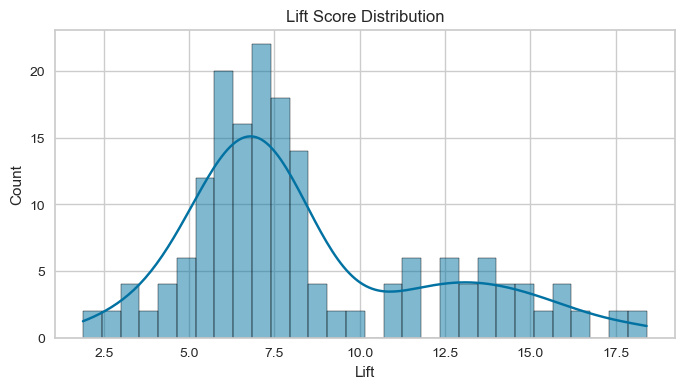

In [278]:
# Visualize lift distribution
plt.figure(figsize=(8, 4))
sns.histplot(rules['lift'], bins=30, kde=True)
plt.title("Lift Score Distribution")
plt.xlabel("Lift")
plt.savefig('plots/lift_score_distribution.png')
plt.show()

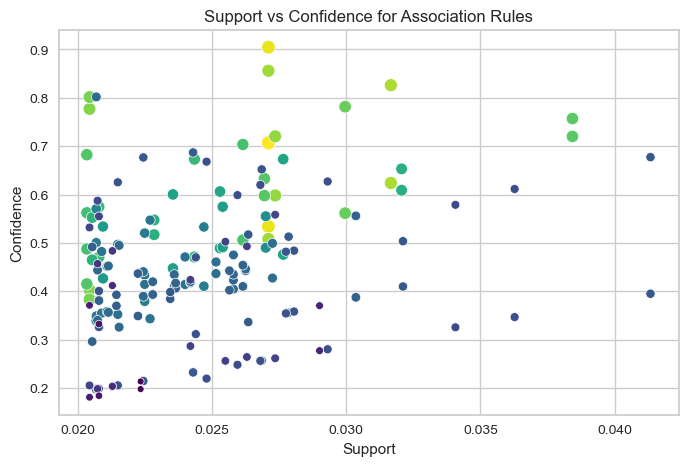

In [279]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=rules, x='support', y='confidence', size='lift', hue='lift', palette='viridis', legend=False)
plt.title('Support vs Confidence for Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

## Product Placement Recommendation

In [280]:
for _, row in rules.head(10).iterrows():
    antecedents = " & ".join(list(row['antecedents']))
    consequents = " & ".join(list(row['consequents']))
    print(f"Place {antecedents} near {consequents} "
          f"(Lift: {row['lift']:.2f}, Confidence: {row['confidence']:.2f})")


Place ROSES REGENCY TEACUP AND SAUCER  & GREEN REGENCY TEACUP AND SAUCER near PINK REGENCY TEACUP AND SAUCER (Lift: 18.40, Confidence: 0.71)
Place PINK REGENCY TEACUP AND SAUCER near ROSES REGENCY TEACUP AND SAUCER  & GREEN REGENCY TEACUP AND SAUCER (Lift: 18.40, Confidence: 0.71)
Place ROSES REGENCY TEACUP AND SAUCER  & PINK REGENCY TEACUP AND SAUCER near GREEN REGENCY TEACUP AND SAUCER (Lift: 17.83, Confidence: 0.90)
Place GREEN REGENCY TEACUP AND SAUCER near ROSES REGENCY TEACUP AND SAUCER  & PINK REGENCY TEACUP AND SAUCER (Lift: 17.83, Confidence: 0.53)
Place PINK REGENCY TEACUP AND SAUCER near GREEN REGENCY TEACUP AND SAUCER (Lift: 16.28, Confidence: 0.83)
Place GREEN REGENCY TEACUP AND SAUCER near PINK REGENCY TEACUP AND SAUCER (Lift: 16.28, Confidence: 0.62)
Place PINK REGENCY TEACUP AND SAUCER & GREEN REGENCY TEACUP AND SAUCER near ROSES REGENCY TEACUP AND SAUCER  (Lift: 16.04, Confidence: 0.86)
Place ROSES REGENCY TEACUP AND SAUCER  near PINK REGENCY TEACUP AND SAUCER & GREEN 